# Конкурс для начинающих Data Scientist от ГИС (ГазИнформСервис)
## 1. Исходные данные, постановка задачи, методика решения
### 1.1. Формат и типы данных

Нам даны данные с бортовых датчиков в зависимости от временной отметки (timestamp) для транспортных средств за период январь-июнь 2020 года, а именно:

* Показания **альтиметра** и **спидометра** (`vehicleID_speedAndHeight_public.csv`) _в метрах_ и _километрах в час_ соответственно
* Показания **тахометра** (`vehicleID_tachometer_public.csv`) _в оборотах в минуту_
* Показания датчика **замка зажигания** (`vehicleID_ingection_public.csv`) (в формате 0/1, где 0 соответствует выключенному состоянию, а 1 -- включённому)
* Уровень **топлива** (`vehicleID_fuelLevel_public.csv`) в _литрах_

Данные представлены в формате **CSV** (comma-separated-values), а в качестве разделителя используется знак точки с запятой -- `;`.

### 1.2. Понимание предметной области

Компании используют множество транспортных средств для ведения своей деятельности, для лучшего мониторинга технического состояния транспортного средства, специфики его использования, улучшения бизнес-процессов внутри компании на машины часто устанавливают серию датчиков, а затем команда аналитиков пытается выявить какие-то закономерности или аномалии в них.

Одна из частых проблем при эксплуатации автомобиля -- нерациональный расход топлива, который может возникнуть из-за неправильной эксплуатации транспортного средства или из-за прямого вмешательства и механического изменения уровня топлива в нём, что может быть классифицировано как кража.

### 1.3. Формулировка задачи

В ходе анализа данных с бортовых датчиков предлагается решить следующие задачи:
* Выявить заправки и сливы (хищения) топлива
* Выявить режим работы техники с наибольшим расходом топлива
* Выявить режимы перевозки грузов
* Определить стиль вождения
* Классифицировать транспортные средства по типам (специальные/грузовые/легковые)

### 1.4. Описание методики решения


In [1]:
import os
os.chdir('./vehicle_dataset_public/')

In [3]:
# import library for table-view representation and to operate with data more easy
import pandas as pd
# input files for vehicle: 
# fuelLevel (T), ingection (T), refueling2 (T), speedAndHeight (T), tachometer (T)

In [7]:
# данные по уровню топлива (непрерывный признак)
df_test = pd.read_csv('./vehicle1_fuelLevel_public.csv', sep=';')
df_test.dtypes

DTIME      object
BEVALUE    object
dtype: object

In [8]:
# данные по зажиганию (бинарный признак)
pd.read_csv('./vehicle1_refueling2_public.csv', sep=';')

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,"46,7","38,4"
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,"38,4","56,7"
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,"56,3",51
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51,"43,9"
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,"43,9","23,5"
...,...,...,...,...,...
98,1,2020-06-26 17:13:03,2020-06-26 18:57:03,"49,3","39,2"
99,1,2020-06-26 18:57:03,2020-06-26 19:04:00,"39,2","59,7"
100,1,2020-06-26 19:04:00,2020-06-26 21:20:41,"59,7","32,2"
101,1,2020-06-26 22:00:39,2020-06-27 00:11:16,"32,2","7,3"


In [10]:
! cat ./../readme_from_authors.txt



























В названиях файлов TSID означает идентификатор ТС.

In [10]:
# Скорость, ключ зажигания (бинарный признак), высота над уровнем моря и скорость передвижения
# , скорость вращения двигателя (об/мин), 

In [11]:
import pandas as pd

In [32]:
# get all files with vehicle word in name
filenames = [filename for filename in os.listdir() if filename.find('vehicle') != -1]

In [33]:
def get_unique_vehicles_sensors(filenames):
    vehicles, sensors = set(), set()
    for filename in filenames:
        vehicle_name, sensor_type, _ = filename.split('_')
        vehicles.add(vehicle_name)
        sensors.add(sensor_type)
    return list(vehicles), list(sensors)

In [34]:
vehicles, sensors = get_unique_vehicles_sensors(filenames)

In [86]:
# sort vehicle names and sensor types
vehicles.sort()
sensors.sort()

# show it
vehicles, sensors

(['vehicle1', 'vehicle19', 'vehicle28', 'vehicle3', 'vehicle5'],
 ['fuelLevel', 'ingection', 'refueling2', 'speedAndHeight', 'tachometer'])

In [89]:
vehicles_data = pd.Series()
for vehicle_name in vehicles:
    vehicle = pd.Series()
    for sensor in sensors:
        sensor_df = pd.read_csv('_'.join([vehicle_name, sensor, 'public.csv']), sep=';')
        vehicle[sensor] = sensor_df
    vehicles_data[vehicle_name] = vehicle

In [90]:
def convert_number(num_as_string):
    """
        function converts numbers from string format N,n (replace all commas with dots) 
        to pandas Series float value format N.n (real number)
    """

    return num_as_string.str.replace(',', '.').astype('float')


def convert_date(date_as_string):
    """
        function converts date from string to datetime64 pandas date format
    """
    
    return date_as_string.astype('datetime64')


# replace commas with dots and change type from object to float64
for vehicle in vehicles:
    # fuelLevel dataset preproccess
    for sensor in sensors:
        sensor_data = vehicles_data[vehicle][sensor]
        values = sensor_data.columns
        for value in values:
            # three types: int | float | date
            # need to become: int->int str->float (if BEVALUE) and not int64 already
            # check correctness using print(vehicle, sensor, sensor_data, value)
            if sensor_data[value].dtype == 'object':
                date_like_columns = ['DTIME', 'STARTDATE', 'ENDDATE']
                if value in date_like_columns:
                    sensor_data[value] = convert_date(sensor_data[value])
                else:
                    sensor_data[value] = convert_number(sensor_data[value])
            # if not object do nothing (cause int64 -> (goes to) int64 by default)

In [91]:
vehicles_data['vehicle1'].fuelLevel.dtypes

DTIME      datetime64[ns]
BEVALUE           float64
dtype: object

In [537]:
# generate some new features such as max_fuel
for vehicle in vehicles:
    # fuel level features
    current_vehicle = vehicles_data[vehicle]
    df = current_vehicle.fuelLevel
    current_vehicle['max_fuel'] = df.BEVALUE.max()
    
    # height features
    df = current_vehicle.speedAndHeight
    current_vehicle['max_height'] = df.HEIGHT.max()
    current_vehicle['min_height'] = df.HEIGHT.min()
    current_vehicle['avg_height'] = df.HEIGHT.mean()
    current_vehicle['range_height'] = df.HEIGHT.max() - df.HEIGHT.min()
    
    # speed features
    vehicles_data[vehicle]['max_speed'] = df.SPEED.max()
    # vehicles_data[vehicle]['min_speed'] = df.SPEED.min() -- not informative cause min is 0 for all
    vehicles_data[vehicle]['avg_speed'] = df.SPEED.mean()
    # vehicles_data[vehicle]['range_speed'] = df.SPEED.max() - df.SPEED.min() -- not informative cause max_speed
    
    # tachometer features
    df = current_vehicle.tachometer
    current_vehicle['avg_rotations'] = df.BEVALUE.mean()
    current_vehicle['median_rotations'] = df.BEVALUE.median()

Анализ максимального уровня топлива в баках за весь предоставленный период времени может свидетельствовать о том, что vehicle28 и vehicle1 с максимальным объемом в 60 литров с больой вероятностью являются легковыми автомобилями.

Таким же является vehicle5 с максимальным объемом в 73,5 литра.

Транспортное средство с идентификатором vehicle19 относится к типу (???)

vehicle3 -- фура с самым большим из представленных баков, предназначена для транспортировки грузов на дальние расстояния, магистральный тягач типа MAN, 279.8 (280) литров.

In [538]:
# make dataframe with new features
vehicles_df = pd.DataFrame()
for vehicle in vehicles:
    # get only features generated by us
    generated_features = list(set(vehicles_data[vehicle].index) - set(sensors))
    vehicles_df[vehicle] = vehicles_data[vehicle][generated_features]

In [534]:
vehicles_data['vehicle1'].fuelLevel.BEVALUE

0         0.0
1         0.0
2         0.0
3        49.7
4        49.9
         ... 
19027    54.0
19028    54.2
19029    54.0
19030    54.2
19031    54.4
Name: BEVALUE, Length: 19032, dtype: float64

In [539]:
vehicles_df

,vehicle1,vehicle19,vehicle28,vehicle3,vehicle5
min_height,-1503.6,-46.6,-2561.8,-79.7,-3228.2
avg_speed,52.3975,1.98549,42.1614,29.6963,59.0354
avg_height,37.0444,81.3893,61.5954,56.7928,52.983
range_height,3697,2859.4,2937.1,246.8,6486.9
sum_fuel,12535.7,985.3,20245.3,5141.3,11151.5
defuel_periods,"4288 2020-02-25 09:19:18 Name: DTIME, dtype:...","Series([], Name: DTIME, dtype: datetime64[ns])",232 2020-01-09 16:25:33 993 2020-01-14...,"Series([], Name: DTIME, dtype: datetime64[ns])","Series([], Name: DTIME, dtype: datetime64[ns])"
median_rotations,2400,1190,2272,1186.5,1968
sum_defuel,31.7,0,1869.1,0,0
max_height,2193.4,2812.8,375.3,167.1,3258.7
avg_rotations,2315.6,1166.82,1914.68,1197.5,1889.08


In [540]:
vdft = vehicles_df.transpose()
vdft

,min_height,avg_speed,avg_height,range_height,sum_fuel,defuel_periods,median_rotations,sum_defuel,max_height,avg_rotations,fuel_periods,max_fuel,max_speed
vehicle1,-1503.6,52.3975,37.0444,3697,12535.7,"4288 2020-02-25 09:19:18 Name: DTIME, dtype:...",2400,31.7,2193.4,2315.6,3 2020-01-09 10:05:26 25 2020-01-14...,60,129
vehicle19,-46.6,1.98549,81.3893,2859.4,985.3,"Series([], Name: DTIME, dtype: datetime64[ns])",1190,0,2812.8,1166.82,464 2020-01-13 07:22:33 2011 2020-03-03 1...,95,57
vehicle28,-2561.8,42.1614,61.5954,2937.1,20245.3,232 2020-01-09 16:25:33 993 2020-01-14...,2272,1869.1,375.3,1914.68,2 2020-01-09 08:19:06 5 2020-01-09...,60,122
vehicle3,-79.7,29.6963,56.7928,246.8,5141.3,"Series([], Name: DTIME, dtype: datetime64[ns])",1186.5,0,167.1,1197.5,1 2020-01-09 08:40:43 273 2020-02-10 0...,279.8,227
vehicle5,-3228.2,59.0354,52.983,6486.9,11151.5,"Series([], Name: DTIME, dtype: datetime64[ns])",1968,0,3258.7,1889.08,19 2020-01-10 09:57:40 62 2020-01-10...,73.5,132


In [108]:
from matplotlib import pyplot as plt

In [156]:
dp = list(vdft[['max_fuel', 'avg_speed']].values)
dp

[array([60.0, 52.397460664742574], dtype=object),
 array([95.0, 1.985494106980961], dtype=object),
 array([60.0, 42.161399705980195], dtype=object),
 array([279.8, 29.696296296296296], dtype=object),
 array([73.5, 59.03544883970601], dtype=object)]

In [157]:
X = [el[0] for el in dp]
y = [el[1] for el in dp]

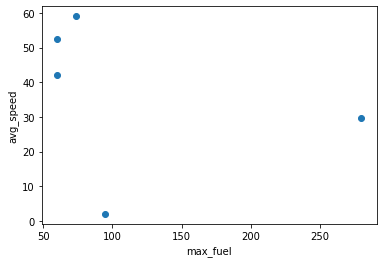

<Figure size 864x864 with 0 Axes>

In [393]:
plt.scatter(X, y)
plt.xlabel('max_fuel')
plt.ylabel('avg_speed')
plt.figure(figsize=(12,12))
plt.show()

Признаки, которые нужно добавить для классификации ТС:
* число заправок в час / периодичность заправок / 

Заправки/сливы мы определили?

**Оконные вещи:**
* Скачки скорости
* Длительность сессии неспешной езды (или что-то типа)
* Длительность ускорений (средняя или медианная)
* Длительность 

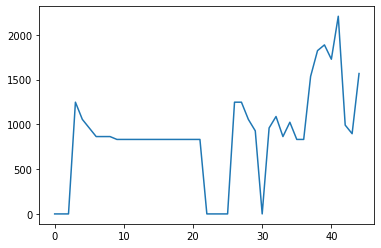

In [159]:
plt.plot(list(vehicles_data['vehicle1'].tachometer.BEVALUE[:45]))

In [335]:
for vehicle in vehicles:
    fuel_values = list(vehicles_data[vehicle].fuelLevel.BEVALUE)
    fuel_times = list(vehicles_data[vehicle].fuelLevel.DTIME)
    in_drive_flag = list(vehicles_data[vehicle].ingection.BEVALUE)
    
    defuel_indexes = []
    defuel_amounts = []
    fuel_indexes = []
    fuel_amounts = []
    
    DEFUEL_THRESHOLD = 10 # litres
    FUEL_THRESHOLD = 20 # litres
    
    for i in range(0, len(fuel_values) - 1):
        # defuels
        if (fuel_values[i] - fuel_values[i+1] > DEFUEL_THRESHOLD) and \
            ((fuel_times[i+1] - fuel_times[i]).total_seconds() < 100) and \
            (in_drive_flag[i] == 0):
            defuel_indexes.append(i)
            defuel_amounts.append(fuel_values[i])

        # fuels
        if ((fuel_values[i+1] - fuel_values[i]) > FUEL_THRESHOLD):
            fuel_indexes.append(i+1)
            fuel_amounts.append(fuel_values[i+1])
    
    # add this info to vehicle data
    current_vehicle = vehicles_data[vehicle]
    df = current_vehicle.fuelLevel
    current_vehicle['fuel_periods'] = df.DTIME[fuel_indexes]
    current_vehicle['defuel_periods'] = df.DTIME[defuel_indexes]
    
    # add info about sum of fuels / defuels
    current_vehicle['sum_fuel'] = sum(fuel_amounts)
    current_vehicle['sum_defuel'] = sum(defuel_amounts)

In [343]:
vehicles_data['vehicle19'].fuelLevel.DTIME == vehicles_data['vehicle19'].ingection.DTIME

ValueError: Can only compare identically-labeled Series objects

In [349]:
mini_series = vehicles_data['vehicle19'].ingection.DTIME[:vehicles_data['vehicle19'].fuelLevel.shape[0]] == vehicles_data['vehicle19'].fuelLevel.DTIME

In [358]:
vehicles_data['vehicle19'].ingection.DTIME.head(30)

0    2020-01-09 06:54:54
1    2020-01-09 06:55:55
2    2020-01-09 06:56:55
3    2020-01-09 06:57:55
4    2020-01-09 06:58:55
5    2020-01-09 06:59:55
6    2020-01-09 07:00:55
7    2020-01-09 07:01:43
8    2020-01-09 07:02:07
9    2020-01-09 07:02:49
10   2020-01-09 07:03:07
11   2020-01-09 07:03:54
12   2020-01-09 07:04:07
13   2020-01-09 07:05:07
14   2020-01-09 07:06:07
15   2020-01-09 07:07:07
16   2020-01-09 07:08:07
17   2020-01-09 07:08:19
18   2020-01-09 07:08:35
19   2020-01-09 07:09:07
20   2020-01-09 07:09:23
21   2020-01-09 07:10:07
22   2020-01-09 07:11:07
23   2020-01-09 07:12:07
24   2020-01-09 07:12:22
25   2020-01-09 07:12:30
26   2020-01-09 07:12:47
27   2020-01-09 07:12:55
28   2020-01-09 07:13:07
29   2020-01-09 07:14:07
Name: DTIME, dtype: datetime64[ns]

In [360]:
vehicles_data['vehicle19'].ingection.DTIME[0].month

1

In [277]:
fuel_times_test = list(vehicles_data['vehicle1'].fuelLevel.DTIME)
(fuel_times_test[1]-fuel_times_test[0]).total_seconds()

62.0

In [308]:
vehicles_data['vehicle5'].fuelLevel.BEVALUE[525:540], vehicles_data['vehicle5'].fuelLevel.DTIME[525:540]
# vehicles_data['vehicle5'].fuelLevel.

(525    15.9
 526    15.9
 527    15.9
 528    15.9
 529    15.9
 530    15.9
 531     0.0
 532    15.5
 533    14.0
 534    13.2
 535    13.2
 536    14.4
 537    14.4
 538    14.2
 539    13.5
 Name: BEVALUE, dtype: float64, 525   2020-01-17 12:14:53
 526   2020-01-17 12:15:53
 527   2020-01-17 12:16:53
 528   2020-01-17 12:17:53
 529   2020-01-17 12:18:53
 530   2020-01-17 12:19:53
 531   2020-01-17 12:20:53
 532   2020-01-17 12:24:21
 533   2020-01-17 12:25:21
 534   2020-01-17 12:26:21
 535   2020-01-17 12:27:21
 536   2020-01-17 12:28:21
 537   2020-01-17 12:29:21
 538   2020-01-17 12:30:21
 539   2020-01-17 12:31:21
 Name: DTIME, dtype: datetime64[ns])

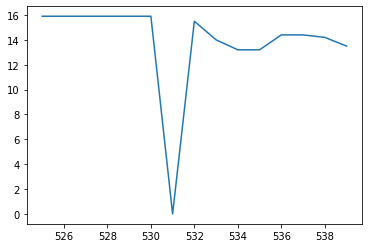

In [310]:
plt.plot(vehicles_data['vehicle5'].fuelLevel.BEVALUE[525:540])

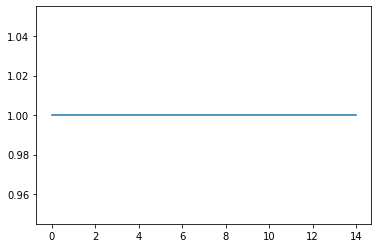

In [312]:
plt.plot(list(vehicles_data['vehicle5'].ingection.BEVALUE[525:540]))

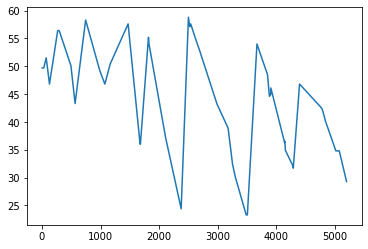

In [239]:
plt.plot(vehicles_data['vehicle1'].fuelLevel.BEVALUE[fuel_indexes[:50]])

In [272]:
vehicles_data['vehicle28'].fuelLevel.DTIME[:30]

0    2020-01-09 08:17:06
1    2020-01-09 08:18:06
2    2020-01-09 08:19:06
3    2020-01-09 08:20:06
4    2020-01-09 10:09:14
5    2020-01-09 10:10:14
6    2020-01-09 10:11:14
7    2020-01-09 10:12:14
8    2020-01-09 10:13:36
9    2020-01-09 10:14:36
10   2020-01-09 10:15:36
11   2020-01-09 10:16:36
12   2020-01-09 10:17:36
13   2020-01-09 10:18:36
14   2020-01-09 10:19:36
15   2020-01-09 10:20:36
16   2020-01-09 10:21:36
17   2020-01-09 10:22:36
18   2020-01-09 10:23:36
19   2020-01-09 10:24:36
20   2020-01-09 10:25:36
21   2020-01-09 10:26:36
22   2020-01-09 10:27:36
23   2020-01-09 10:28:36
24   2020-01-09 10:29:36
25   2020-01-09 10:30:36
26   2020-01-09 10:31:36
27   2020-01-09 10:32:36
28   2020-01-09 10:33:36
29   2020-01-09 10:34:36
Name: DTIME, dtype: datetime64[ns]

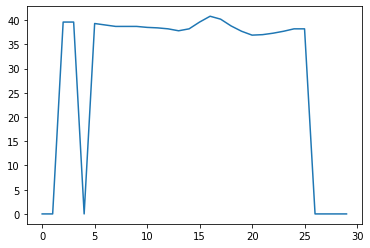

In [271]:
plt.plot(vehicles_data['vehicle28'].fuelLevel.BEVALUE[:30])

In [380]:
ps1 = vehicles_data['vehicle28'].fuelLevel.DTIME.dt.round('T').unique()

In [379]:
ps2 = vehicles_data['vehicle28'].ingection.DTIME.dt.round('T').unique()

In [391]:
pd.Series(ps1)

0       2020-01-09 08:17:00
1       2020-01-09 08:18:00
2       2020-01-09 08:19:00
3       2020-01-09 08:20:00
4       2020-01-09 10:09:00
                ...        
33192   2020-06-30 19:25:00
33193   2020-06-30 19:26:00
33194   2020-06-30 19:27:00
33195   2020-06-30 19:28:00
33196   2020-06-30 19:29:00
Length: 33197, dtype: datetime64[ns]

In [394]:
# vehicles dataset transposed
vdft

,min_height,avg_speed,avg_height,range_height,max_height,max_fuel,max_speed
vehicle1,-1503.6,52.3975,37.0444,3697,2193.4,60,129
vehicle19,-46.6,1.98549,81.3893,2859.4,2812.8,95,57
vehicle28,-2561.8,42.1614,61.5954,2937.1,375.3,60,122
vehicle3,-79.7,29.6963,56.7928,246.8,167.1,279.8,227
vehicle5,-3228.2,59.0354,52.983,6486.9,3258.7,73.5,132


In [408]:
from sklearn.cluster import KMeans

In [488]:
clusterizer = KMeans(n_clusters = 3)
clusterizer.fit(vdft[['avg_speed', 'avg_height', 'max_fuel']])
X = np.array(vdft.avg_speed)
y = np.array(vdft.max_fuel)

In [489]:
import numpy as np

In [490]:
labels = np.array(clusterizer.labels_)

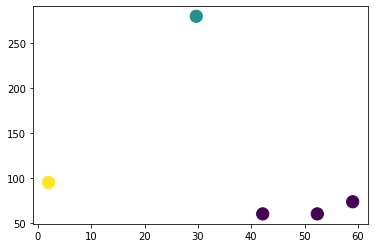

In [491]:
plt.scatter(X, y, c=labels, s=150)

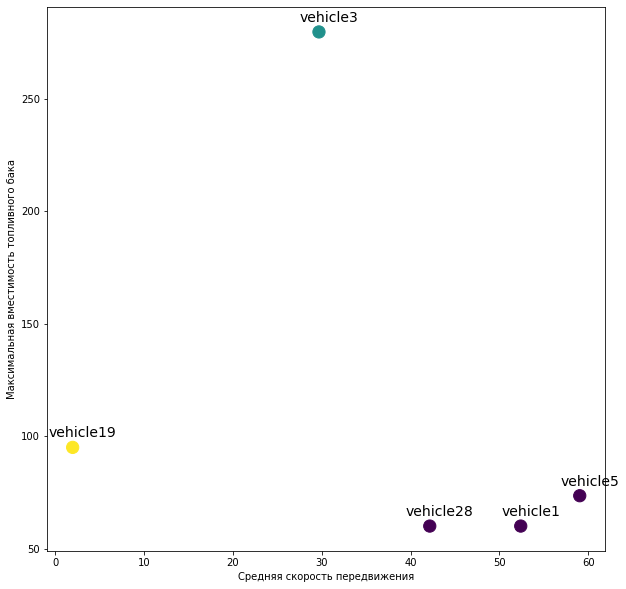

In [531]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y, c=labels, s=150)
plt.xlabel('Средняя скорость передвижения')
plt.ylabel('Максимальная вместимость топливного бака')


for point in enumerate(zip(X, y)):
    
    label = vdft.index[point[0]]
    x_ = point[1][0]
    y_ = point[1][1]

    plt.annotate(label, # this is the text
    (x_, y_), # this is the point to label
    textcoords="offset points", # how to position the text
    xytext=(10, 10), # distance from text to points (x,y)
    fontsize=14,
    ha='center') # horizontal alignment can be left, right or center
plt.show()

In [505]:
next(enumerate(zip(X, y)))

(0, (52.397460664742574, 60.0))

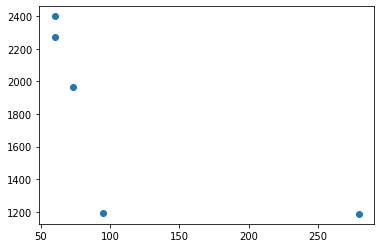

In [545]:
X_new = vdft.max_fuel
y_new = vdft.median_rotations
plt.scatter(X_new, y_new)

SyntaxError: invalid syntax (<ipython-input-544-64b7bb86d3b3>, line 1)